### **Deep Neural Networks for nonlinear feature extraction**


Based on [the implementation of fully-connected deep neural networks at Colab](https://colab.research.google.com/drive/1dznpn8zYNTyuLp0XP1tKetoB7i8XbKV0), the following is an implementation of a nonlinear feature extraction method using deep neural networks with the MNIST dataset (https://www.kaggle.com/datasets/oddrationale/mnist-in-csv).

epoch=0 lr=0.0100 loss=0.15853 accuracy=95.39%
epoch=1 lr=0.0090 loss=0.09776 accuracy=97.15%
epoch=2 lr=0.0081 loss=0.06917 accuracy=98.11%
epoch=3 lr=0.0073 loss=0.05133 accuracy=98.65%
epoch=4 lr=0.0066 loss=0.04407 accuracy=98.77%
epoch=5 lr=0.0059 loss=0.03269 accuracy=99.17%
epoch=6 lr=0.0053 loss=0.02801 accuracy=99.30%
epoch=7 lr=0.0048 loss=0.02569 accuracy=99.43%
epoch=8 lr=0.0043 loss=0.01839 accuracy=99.66%
epoch=9 lr=0.0039 loss=0.01581 accuracy=99.74%
epoch=10 lr=0.0035 loss=0.01360 accuracy=99.80%
epoch=11 lr=0.0031 loss=0.01217 accuracy=99.84%
EVALUATING MLP PERFORMANCE
MLP validation accuracy (10-way classification): 98.05%
Training samples: 12214
Validation samples: 2037
Bottleneck feature dimension: 200
Results for 7 vs 9:
  C = 10, gamma = 0.001
  Training accuracy: 99.97%
  Validation accuracy: 99.31%
  Training time: 1.048s
Training samples: 11774
Validation samples: 1954
Bottleneck feature dimension: 200
Results for 0 vs 8:
  C = 0.1, gamma = 0.001
  Training acc

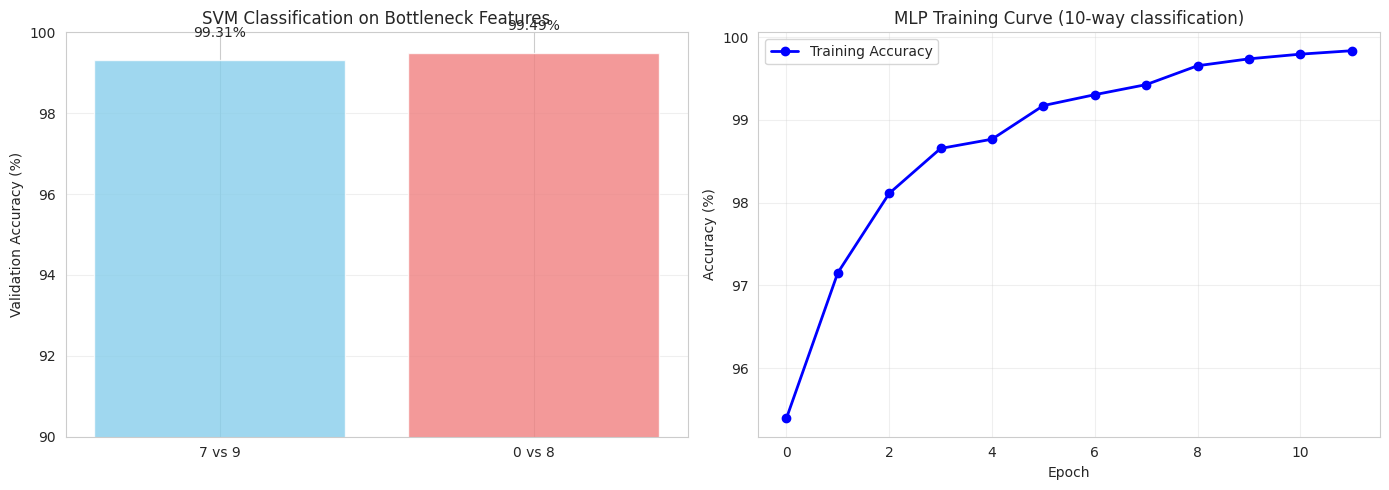

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax.nn as jnn
from jax import random, device_put
from torchvision import datasets
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import time

# --- Load and preprocess MNIST ---
mnist_data = datasets.MNIST('data', train=True, download=True)
mnist_data = list(mnist_data)

# Useing full MNIST training set
mnist_train = list(datasets.MNIST('data', train=True, download=True))

# Use MNIST subset for testing
mnist_val = list(datasets.MNIST('data', train=False, download=True))


# Convert images to flattened arrays in [0,1]
def img_to_array(image):
    return np.array(image).reshape(-1) / 255.0

X_train = np.array([img_to_array(img) for img, lbl in mnist_train])
y_train = np.array([lbl for img, lbl in mnist_train])
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1  # one-hot encoding

X_val = np.array([img_to_array(img) for img, lbl in mnist_val])
y_val = np.array([lbl for img, lbl in mnist_val])
Y_val = np.zeros((y_val.size, 10))
Y_val[np.arange(y_val.size), y_val] = 1

class myMLP2():
    def __init__(self, optimizer='sgd', debug=0, struct=[], activation='relu',
                 loss='ce', lr=1.0, max_epochs=10, batch_size=10, random_state=1,
                 init_range=1.0, annealing=1.0):
        self.optimizer = optimizer
        self.lr = lr
        self.annealing = annealing
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.debug = debug
        self.activation = activation
        self.loss = loss
        self.random_state = random_state
        self.init_range = init_range
        self.struct = struct

    def initialization(self, X, Y):
        key = random.PRNGKey(self.random_state)
        input_dim = X.shape[1]
        self.layers = len(self.struct)
        self.W_b = [0]*(self.layers+1)
        self.W_b_grad = [0]*(self.layers+1)

        for l in range(self.layers):
            output = self.struct[l]
            self.W_b[l] = device_put(4.90*(random.uniform(key,(input_dim+1, output))-0.5)*
                                     self.init_range/jnp.sqrt(output+input_dim))
            self.W_b_grad[l] = device_put(jnp.zeros((input_dim+1, output)))
            input_dim = output

        output = Y.shape[1]
        self.W_b[self.layers] = device_put(4.90*(random.uniform(key,(input_dim+1, output))-0.5)*
                                           self.init_range/jnp.sqrt(output+input_dim))
        self.W_b_grad[self.layers] = device_put(jnp.zeros((input_dim+1, output)))
        return

    def forward(self, W_b, X, return_Z=False):
        Zs = [0]*(self.layers+2) if return_Z else [0]
        Z = jnp.hstack((X,jnp.ones((X.shape[0],1),dtype=X.dtype)))
        if return_Z:
            Zs[0] = Z

        for l in range(self.layers):
            Z = jnn.relu(Z @ W_b[l])
            Z = jnp.hstack((Z,jnp.ones((Z.shape[0],1),dtype=Z.dtype)))
            if return_Z:
                Zs[l+1] = Z

        l = self.layers
        y = jnn.softmax(Z @ W_b[l], axis=1)
        if return_Z:
            Zs[l+1] = y
        else:
            Zs[0] = y
        return Zs

    def backward(self, X, Y, Zs):
        l = len(Zs)-1
        e = Zs[l] - Y
        WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
        self.W_b_grad[l-1] = jnp.mean(WG,axis=0)

        for l in range(self.layers,0,-1):
            e = ( e @ self.W_b[l].T ) * jnp.heaviside(Zs[l],0)
            e = jnp.delete(e, -1, axis=1)
            WG = jnp.einsum('bo,bi->bio', e, Zs[l-1])
            self.W_b_grad[l-1] = jnp.mean(WG,axis=0)
        return

    def loss_ce_batch(self, W_b, X, Y):
        R = self.forward(W_b, X, return_Z=False)
        return -jnp.mean(jnp.log(R[0][Y==1]+1e-8))

    def sgd(self, X, Y):
        n = X.shape[0]
        lr = self.lr
        errorsA = np.zeros(self.max_epochs)
        errorsC = np.zeros(self.max_epochs)

        for epoch in range(self.max_epochs):
            indices = np.random.permutation(n)
            for batch_start in range(0, n, self.batch_size):
                X_batch = X[indices[batch_start:batch_start+self.batch_size]]
                Y_batch = Y[indices[batch_start:batch_start+self.batch_size]]

                Zs = self.forward(self.W_b, X_batch, return_Z=True)
                self.backward(X_batch, Y_batch, Zs)

                for l in range(self.layers+1):
                    self.W_b[l] -= lr * self.W_b_grad[l]

            errorsC[epoch] = self.loss_ce_batch(self.W_b, X, Y)
            result = self.predict(X)
            errorsA[epoch] =  jnp.count_nonzero(jnp.equal(result, y_train))/y_train.size

            if self.debug:
                print(f'epoch={epoch} lr={lr:.4f} loss={errorsC[epoch]:.5f} accuracy={100*errorsA[epoch]:.2f}%')

            lr *= self.annealing
        return errorsA, errorsC

    def fit(self, X, Y):
        self.initialization(X, Y)
        X2 = device_put(X)
        Y2 = device_put(Y)
        errorsA, errorsC = self.sgd(X2, Y2)
        return errorsA, errorsC

    def predict(self, X):
        X2 = device_put(X)
        Y = self.forward(self.W_b, X2)
        return jnp.argmax(Y[0], axis=1)

mlp = myMLP2(struct=[800, 400, 200], debug=1, max_epochs=12, annealing=0.9, batch_size=10,lr=0.01 )


errorsA, errorsC = mlp.fit(X_train, Y_train)

#layer_index=None , change to specified layer
def extract_bottleneck_features(mlp, X, layer_index=None):

    X2 = device_put(X)
    Zs = mlp.forward(mlp.W_b, X2, return_Z=True)

    # default is last hidden layer (if unspecified)
    if layer_index is None:
        layer_index = mlp.layers  # same as before

    bottleneck = Zs[layer_index][:, :-1]
    return np.array(bottleneck)


def evaluate_svm_on_digit_pair(mlp, digit_pair, X_train, y_train, X_val, y_val, C, gamma):

    #uses mask to select only specified pair for training
    mask_train = np.isin(y_train, digit_pair)
    X_train_pair = X_train[mask_train]
    y_train_pair = y_train[mask_train]

    # same for testing
    mask_val = np.isin(y_val, digit_pair)
    X_val_pair = X_val[mask_val]
    y_val_pair = y_val[mask_val]

    print(f"Training samples: {X_train_pair.shape[0]}")
    print(f"Validation samples: {X_val_pair.shape[0]}")

    # Extract bottleneck features
    bottleneck_train = extract_bottleneck_features(mlp, X_train_pair)
    bottleneck_val = extract_bottleneck_features(mlp, X_val_pair)

    print(f"Bottleneck feature dimension: {bottleneck_train.shape[1]}")

    # Standardize features
    scaler = StandardScaler()
    bottleneck_train_scaled = scaler.fit_transform(bottleneck_train)
    bottleneck_val_scaled = scaler.transform(bottleneck_val)

    # Convert labels to binary classification (+1, -1)
    y_train_binary = np.where(y_train_pair == digit_pair[0], 1, -1)
    y_val_binary = np.where(y_val_pair == digit_pair[0], 1, -1)

    # Use specified hyperparameters for C and gamma
    start = time.time()

    svm = SVC(kernel='rbf', C=C, gamma=gamma)
    svm.fit(bottleneck_train_scaled, y_train_binary)

    train_pred = svm.predict(bottleneck_train_scaled)
    val_pred = svm.predict(bottleneck_val_scaled)

    train_acc = np.mean(train_pred == y_train_binary)
    val_acc = np.mean(val_pred == y_val_binary)
    end = time.time()

    print(f"Results for {digit_pair[0]} vs {digit_pair[1]}:")
    print(f"  C = {C}, gamma = {gamma}")
    print(f"  Training accuracy: {100*train_acc:.2f}%")
    print(f"  Validation accuracy: {100*val_acc:.2f}%")
    print(f"  Training time: {end - start:.3f}s")

    return {
        'C': C,
        'gamma': gamma,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'time': end - start
    }


# Evaluate MLP performance on validation set
print("EVALUATING MLP PERFORMANCE")
result = mlp.predict(X_val)
mlp_val_acc = 100.0 * jnp.count_nonzero(jnp.equal(result, y_val)) / y_val.size
print(f'MLP validation accuracy (10-way classification): {mlp_val_acc:.2f}%')

# Evaluate SVM on bottleneck features for digit pair 7 vs 9
result_79 = evaluate_svm_on_digit_pair(
    mlp, [7, 9], X_train, y_train, X_val, y_val, 10, 0.001)

# Evaluate SVM on bottleneck features for digit pair 0 vs 8
result_08 = evaluate_svm_on_digit_pair(
    mlp, [0, 8], X_train, y_train, X_val, y_val, 0.1, 0.001)

# Summary
print("FINAL SUMMARY")
print(f"\nMLP Architecture: {mlp.struct}")
print(f"Bottleneck dimension: {mlp.struct[-1]}")
print(f"MLP 10-way classification accuracy: {mlp_val_acc:.2f}%")

print(f"\nDigit pair 7 vs 9:")
print(f"  Best C: {result_79['C']}, gamma: {result_79['gamma']}")
print(f"  Validation accuracy: {100*result_79['val_acc']:.2f}%")

print(f"\nDigit pair 0 vs 8:")
print(f"  Best C: {result_08['C']}, gamma: {result_08['gamma']}")
print(f"  Validation accuracy: {100*result_08['val_acc']:.2f}%")



# plotting for visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparing results
digit_pairs = ['7 vs 9', '0 vs 8']
val_accs = [100*result_79['val_acc'], 100*result_08['val_acc']]

axes[0].bar(digit_pairs, val_accs, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('SVM Classification on Bottleneck Features')
axes[0].set_ylim([90, 100])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(val_accs):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom')

# Learning curves from MLP training
epochs = np.arange(len(errorsA))
axes[1].plot(epochs, 100*errorsA, 'b-o', label='Training Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('MLP Training Curve (10-way classification)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

**Discussion:**

Initially I tried a simple two layer [500, 250] network, and then a deeper one with more neurons: [800, 600, 400, 200]. After performing a grid search at this stage with C_values = [0.1, 1, 10, 100] and gamma_values = [0.001, 0.01, 0.1, 1] I found overall gamma = 0.001 to be the best. From there, after an adjustment of the architecture to current layer values, [800, 400, 200], and another search of C in [0.1, 1, 10, 100], the result was that they were all pretty similar in terms of validation accuracy. Thus the difference in selecting C = 10 for 7 vs 9 and C=0.1 for 0 vs 8 is so slight that that it is reasonable to explain the difference to be simply from noise.

The improvement in the architecture in three layers versus the original two could be attributed to a more gradual bottleneck. This allowed the network to overall have a better feature extraction in that the aggressive two layer approach caused it to eliminate more important features earlier on. The optimal results from a smaller gamma size in this case could be attributed to individual examples having less impact on the training of the model and therefore avoiding overfitting.

Overall, I propose that the neural network was able to extract useful discriminatory features to make the task given to the SVM simpler to make the digit pairs more separable in the bottleneck space than in the original pixel space. This can be substantiated by the fact that the a linear model was able to 99.31% and 99.49%.